In [1]:
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import csv
import ast
from brokenaxes import brokenaxes

In [2]:
# find all CSVs one level up (kernel-survey)
csv_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
csv_files = glob.glob(os.path.join(csv_dir, '*.csv'))

# read each csv, tag with its filename, collect into a list
dfs = []
for path in csv_files:
    df = pd.read_csv(path, quotechar='"', quoting=csv.QUOTE_NONNUMERIC)
    df['filename'] = os.path.basename(path)
    dfs.append(df)

# concatenate all dataframes
df = pd.concat(dfs, ignore_index=True)

# now you can explore or visualize
print(df.shape)
print(df.columns)

(110, 43)
Index(['source_code', 'combined_name', 'kernel_name', 'exec_args', 'grid_size',
       'block_size', 'total_num_threads', 'empirical_sp_flop_count',
       'empirical_dp_flop_count', 'src_concretized_input_args',
       'step1_messages', 'concretizationState', 'src_single_kernel_execution',
       'step2_messages', 'srcSingleKernelState',
       'snippet_first_kernel_invocation', 'snippet_kernel_src',
       'snippet_kernel_src_concretized_values', 'step5_messages',
       'snippetConcretizationState', 'kernel_annotated_warp_divergence',
       'kernel_annotated_WDPs', 'wdps_list', 'wdp_processing_index',
       'wdps_num_executions', 'kernel_annotated_num_ops', 'step8_messages',
       'numOpsAnnotationState', 'summed_kernel_ops', 'sp_flop_diff',
       'dp_flop_diff', 'sp_flop_perc_diff', 'dp_flop_perc_diff',
       'input_tokens', 'output_tokens', 'total_cost', 'trial', 'modelName',
       'top_p', 'temp', 'totalQueryTime', 'error', 'filename'],
      dtype='object')


In [3]:
def classify_success(error_str):
    if error_str is np.nan:
        return 'Success'
    elif "QUERY TIMEOUT EVENT" in error_str:
        return 'Timeout'
    else:
        return 'Failed'

def sum_costs(cost_str):
    if cost_str is np.nan:
        return 0
    else:
        return sum(float(x) for x in ast.literal_eval(cost_str)) 

# add a success column
df['success'] = df['error'].apply(classify_success)
df['totalQueryTime'] = df['totalQueryTime'].astype(float)
df['total_query_cost'] = df['total_cost'].apply(sum_costs)

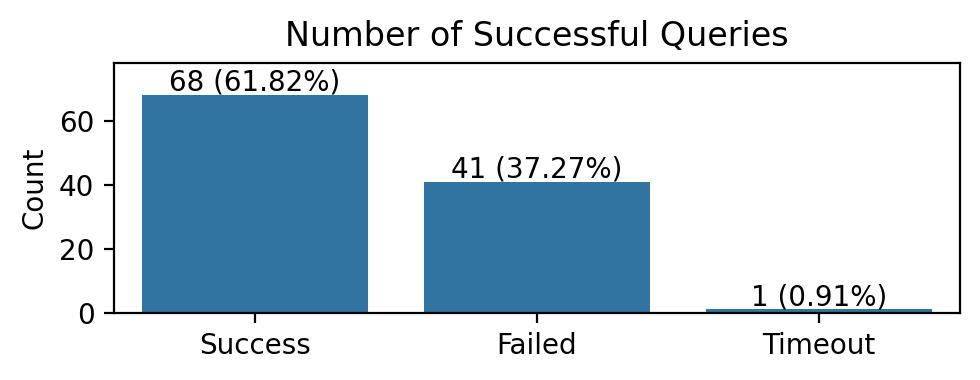

In [4]:
# make a seaborn plot showing the number of successful and not-successful elements in the df

plt.figure(figsize=(5, 2), dpi=200)
ax = sns.countplot(x='success', data=df)

# adjust y-limit so annotations fit
max_count = df['success'].value_counts().max()
ax.set_ylim(0, max_count * 1.15)

# add count labels on top of each bar
for p in ax.patches:
    count = int(p.get_height())
    percent = count / len(df) * 100
    ax.text(
        p.get_x() + p.get_width() / 2,
        p.get_height() + max_count * 0.02,
        f"{count} ({percent:.2f}%)",
        ha='center'
    )

#plt.xlabel('Outcome')
plt.xlabel('')
plt.ylabel('Count')
plt.title('Number of Successful Queries')
#plt.xticks([0, 1], ['Failed', 'Successful'])
plt.tight_layout()
plt.show()

In [5]:
success_df = df[df['success'] == 'Success']

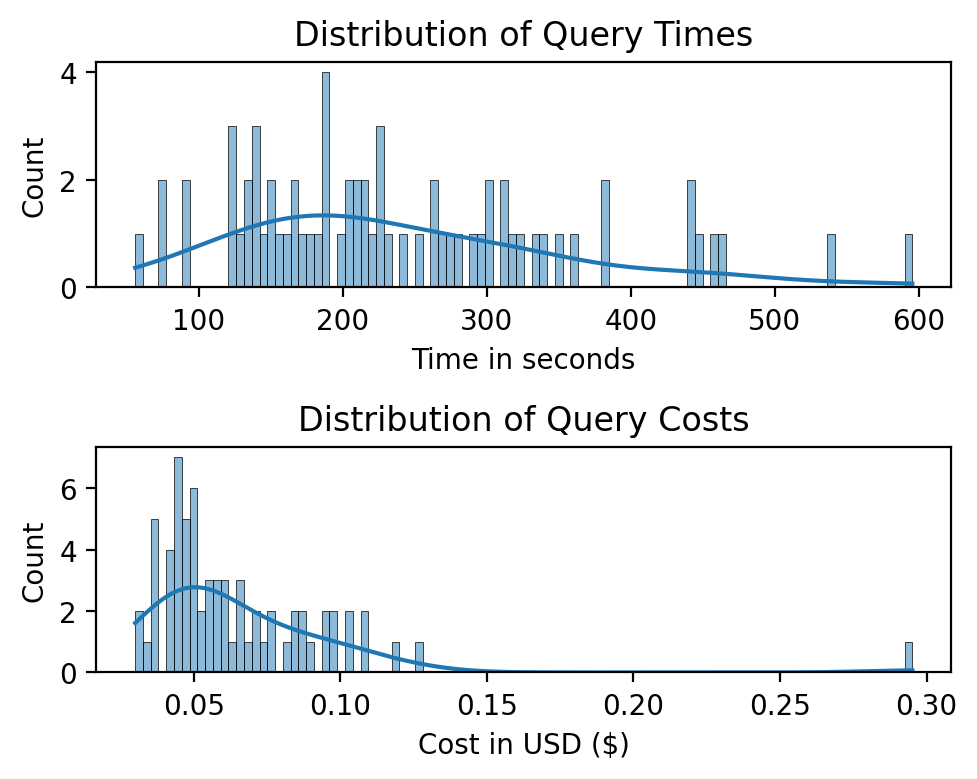

In [6]:
# now let's check the distribution of the query times and costs on two axes
bins = 100
fig, (ax1, ax2) = plt.subplots(2, 1,
                               figsize=(5, 4),  # taller to fit both
                               dpi=200,
                               sharex=False)   # you can set True if you want to share x
sns.histplot(success_df['totalQueryTime'], bins=bins, kde=True, ax=ax1)
ax1.set_title('Distribution of Query Times')
ax1.set_xlabel('Time in seconds')
ax1.set_ylabel('Count')

sns.histplot(success_df['total_query_cost'], bins=bins, kde=True, ax=ax2)
ax2.set_title('Distribution of Query Costs')
ax2.set_xlabel('Cost in USD ($)')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()

Covariance matrix:
 [[ 1.05999174e-09 -2.55490118e-07]
 [-2.55490118e-07  7.53847561e-05]]


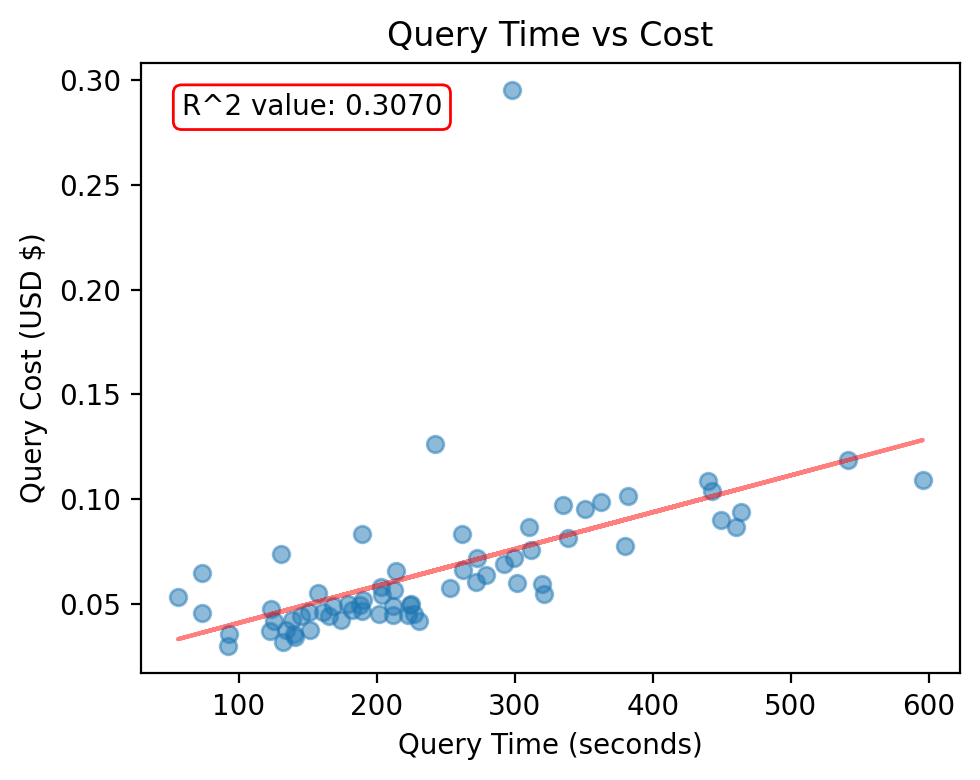

In [7]:
# scatter plot of query time vs cost
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=200)
ax.scatter(success_df['totalQueryTime'], success_df['total_query_cost'], alpha=0.5)

# display a line of best fit
z, cov = np.polyfit(success_df['totalQueryTime'],
                    success_df['total_query_cost'],
                    deg=1, cov=True)
p = np.poly1d(z)
x = success_df['totalQueryTime'].values
predicted = p(x)
ax.plot(x, predicted, color='red', alpha=0.5)

# print the R^2 value on the plot
r_squared = np.corrcoef(success_df['totalQueryTime'], success_df['total_query_cost'])[0, 1] ** 2
ax.text(0.05, 0.95, f"R^2 value: {r_squared:.4f}", transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='red', facecolor='white'))

## compute per-point standard error of the prediction
#var_m = cov[0, 0]
#var_b = cov[1, 1]
#cov_mb = cov[0, 1]
#sigma_pred = np.sqrt(var_b + x**2 * var_m + 2 * x * cov_mb)
#
## 95% confidence band
#upper = predicted + 1.96 * sigma_pred
#lower = predicted - 1.96 * sigma_pred
#ax.fill_between(x, lower, upper, color='red', alpha=0.2)

print("Covariance matrix:\n", cov)

ax.set_xlabel('Query Time (seconds)')
ax.set_ylabel('Query Cost (USD $)')
ax.set_title('Query Time vs Cost')
plt.tight_layout()
plt.show()

In [8]:
nnz_sp_flop_df = success_df[success_df['empirical_sp_flop_count'] > 0]

nnz_dp_flop_df = success_df[success_df['empirical_dp_flop_count'] > 0]

/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_98454/2697845105.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


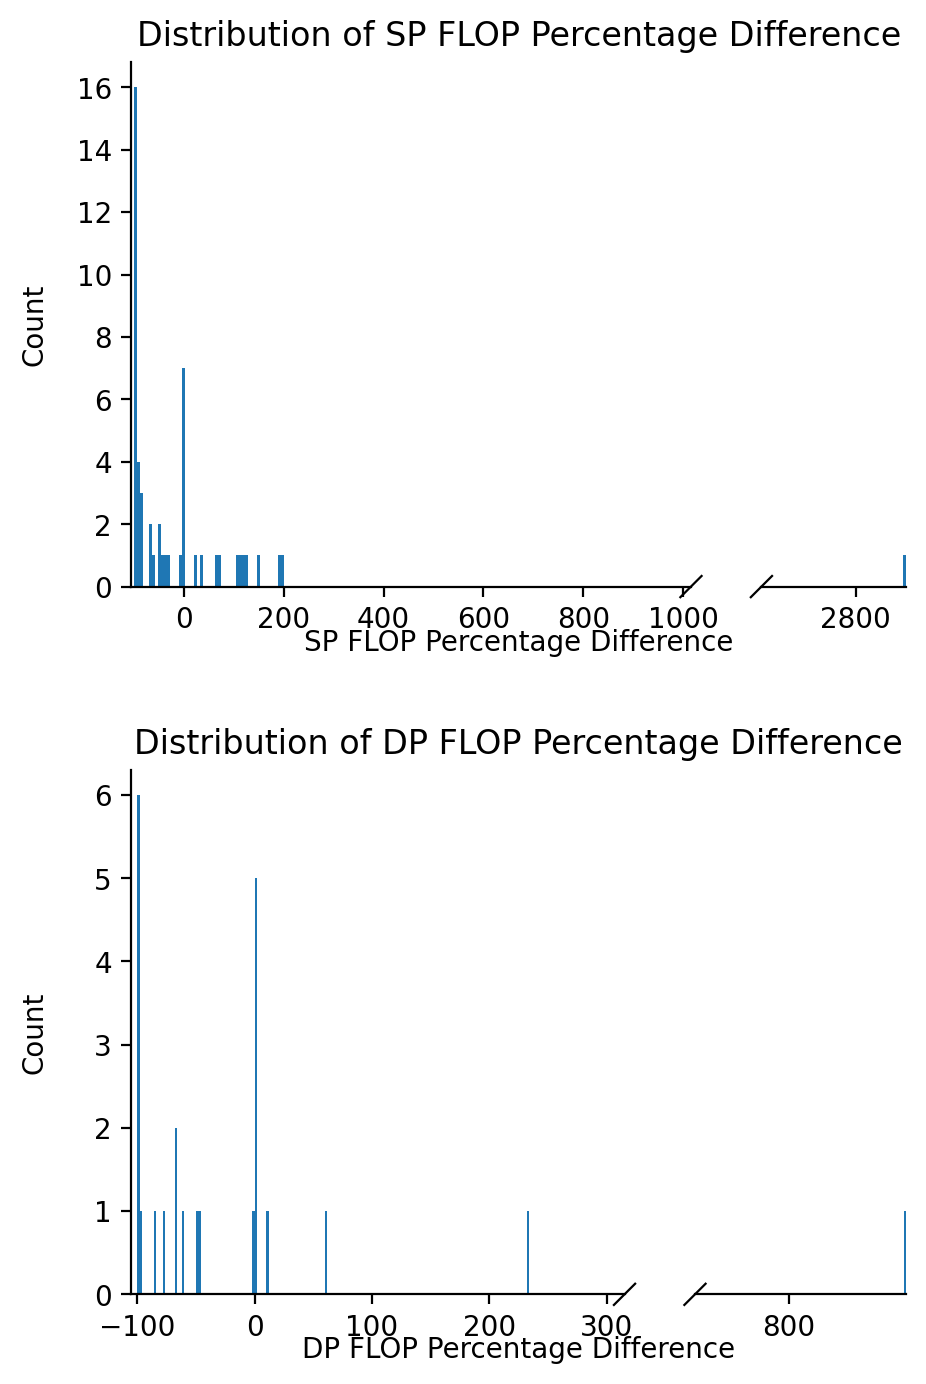

In [9]:
# compute the full tails

sp_min = nnz_sp_flop_df['sp_flop_perc_diff'].min()
dp_min = nnz_dp_flop_df['dp_flop_perc_diff'].min()

sp_max = nnz_sp_flop_df['sp_flop_perc_diff'].max()
dp_max = nnz_dp_flop_df['dp_flop_perc_diff'].max()

fig = plt.figure(figsize=(5, 8), dpi=200)
bins = 500
# layout 2 rows stacked
gs = fig.add_gridspec(2, 1, height_ratios=[1, 1], hspace=0.35)

# SP plot with broken x-axis: zoom in to [-1,1] then skip to the upper tail
ax1 = brokenaxes(xlims=((sp_min*1.05, sp_max*0.35), (sp_max*0.9, sp_max)),
                 subplot_spec=gs[0],
                 hspace=0.05)
ax1.hist(nnz_sp_flop_df['sp_flop_perc_diff'], bins=bins)
ax1.set_title('Distribution of SP FLOP Percentage Difference')
ax1.set_xlabel('SP FLOP Percentage Difference')
ax1.set_ylabel('Count')

# DP plot, same idea
ax2 = brokenaxes(xlims=((dp_min*1.05, dp_max*0.35), (dp_max*0.8, dp_max)),
                 subplot_spec=gs[1],
                 hspace=0.05)
ax2.hist(nnz_dp_flop_df['dp_flop_perc_diff'], bins=bins)
ax2.set_title('Distribution of DP FLOP Percentage Difference')
ax2.set_xlabel('DP FLOP Percentage Difference')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()

In [10]:
# make a scatter plot of the two FLOP percentage differences


In [11]:
from dataclasses import dataclass
import re, ast

@dataclass
class FLOPCounts:
    sp_flop_count: int
    sp_flop_explanation: str
    dp_flop_count: int
    dp_flop_explanation: str

# only match our four fields
_flop_pattern = re.compile(
    r"(sp_flop_count|sp_flop_explanation|dp_flop_count|dp_flop_explanation)"
    r"=('(?:[^']*)'|\d+)"
)

def parse_flop_counts(ops_str):
    matches = _flop_pattern.findall(ops_str)
    d = {}
    for k, v in matches:
        if v.startswith("'"):
            d[k] = ast.literal_eval(v)
        else:
            d[k] = int(v)
    # fill in defaults in case any key is missing
    out = FLOPCounts(
        sp_flop_count       = d.get("sp_flop_count", 0),
        sp_flop_explanation = d.get("sp_flop_explanation", ""),
        dp_flop_count       = d.get("dp_flop_count", 0),
        dp_flop_explanation = d.get("dp_flop_explanation", "")
    )
    return out

success_df['flop_counts'] = (
    success_df['summed_kernel_ops']
      .apply(parse_flop_counts)
)

success_df['sp_flop_predicted'] = success_df['flop_counts'].apply(lambda x: x.sp_flop_count)
success_df['sp_flop_explanation'] = success_df['flop_counts'].apply(lambda x: x.sp_flop_explanation)
success_df['dp_flop_predicted'] = success_df['flop_counts'].apply(lambda x: x.dp_flop_count)
success_df['dp_flop_explanation'] = success_df['flop_counts'].apply(lambda x: x.dp_flop_explanation)

/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_98454/2083037434.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  success_df['flop_counts'] = (
/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_98454/2083037434.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  success_df['sp_flop_predicted'] = success_df['flop_counts'].apply(lambda x: x.sp_flop_count)
/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_98454/2083037434.py:40: SettingWithCopyWarning: 
A value is trying to be

min_sp_dp_flop: 0.0, max_sp_dp_flop: 52494198981.0


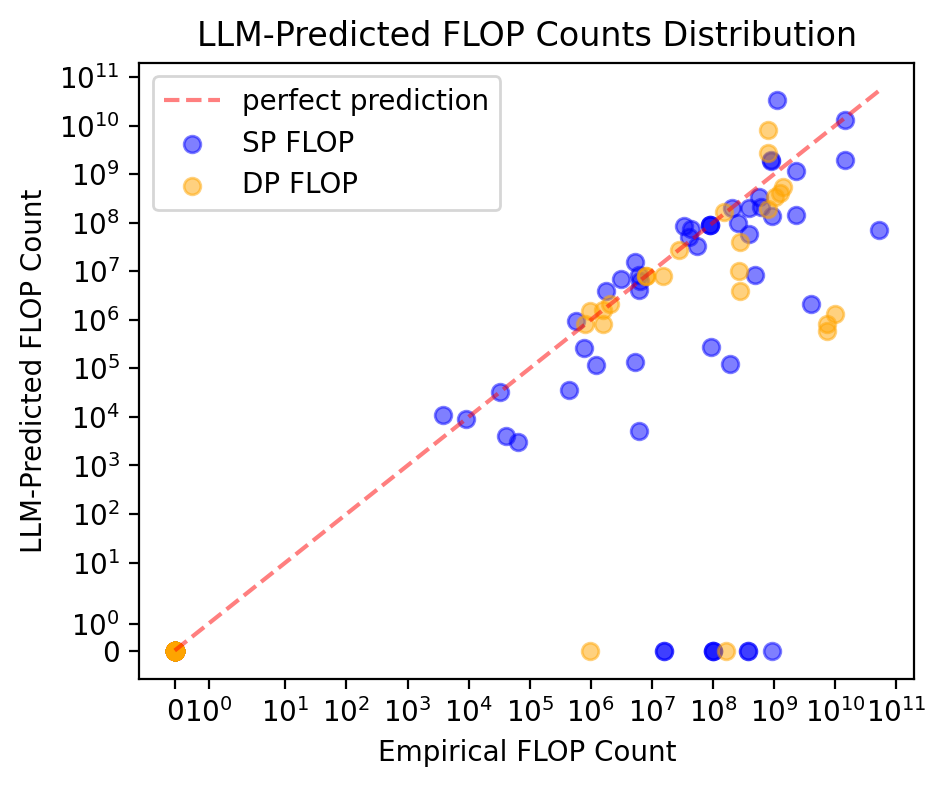

In [12]:
# now lets make a scatter plot of the predicted SP vs DP FLOP counts
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=200)

max_sp_dp_flop = max(
    success_df['empirical_sp_flop_count'].max(),
    success_df['empirical_dp_flop_count'].max(),
    success_df['sp_flop_predicted'].max(),
    success_df['dp_flop_predicted'].max()
)
min_sp_dp_flop = min(
    success_df['empirical_sp_flop_count'].min(),
    success_df['empirical_dp_flop_count'].min(),
    success_df['sp_flop_predicted'].min(),
    success_df['dp_flop_predicted'].min()
)

print(f"min_sp_dp_flop: {min_sp_dp_flop}, max_sp_dp_flop: {max_sp_dp_flop}")

# plot the x-y line on the plot
ax.plot([min_sp_dp_flop, max_sp_dp_flop], [min_sp_dp_flop, max_sp_dp_flop], color='red', linestyle='--', alpha=0.5, label='perfect prediction')

ax.scatter(success_df['empirical_sp_flop_count'], success_df['sp_flop_predicted'], alpha=0.5, label='SP FLOP', color='blue')
ax.scatter(success_df['empirical_dp_flop_count'], success_df['dp_flop_predicted'], alpha=0.5, label='DP FLOP', color='orange')


ax.set_xscale('symlog')
ax.set_yscale('symlog')

#ax.set_xlim(min_sp_dp_flop-100, max_sp_dp_flop)
#ax.set_ylim(min_sp_dp_flop-100, max_sp_dp_flop)
ax.set_title('LLM-Predicted FLOP Counts Distribution')
plt.xlabel('Empirical FLOP Count')
plt.ylabel('LLM-Predicted FLOP Count')
plt.legend()
plt.show()
